In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Dropout, RepeatVector
from keras.metrics import RootMeanSquaredError
%matplotlib inline

Using TensorFlow backend.


### Loading Preprocessed Dataset

In [2]:
df = pd.read_csv('C:/Users/Gj/Documents/Git/macedonian_stock_exchange_market/tmp/mse_raw.csv', 
                 parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [3]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


In [4]:
stocks = ['ALK', 'GRNT', 'KMB', 'MPT']

### setting RNN dataset for different  training, validation and test

### split dataset

In [5]:
new_df = df[['stock_id', 'close']][df['stock_id'].isin(stocks)]

In [6]:
#Create a new dataframe with only closing price column
close_price = []
for stock in stocks:
    sequence_by_stock = new_df['close'][new_df.stock_id == stock]
    #Convert the dataframe into numpy array and make list of each stock
    close_price.append(sequence_by_stock.values)

In [7]:
len(close_price)

4

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
scaled_df = []
for i in range(4):
    scaled_df.append(scaler.fit_transform(close_price[i].reshape(len(close_price[i]), 1)))

### univariate sequence many to many

In [10]:
# function that segments the data
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
# choose a number of time steps
n_steps_in, n_steps_out = 180, 7
n_features = 1

# split the data into samples
X_list = []
y_list = []
for i in range(4):
    X, y = split_sequence(scaled_df[i], n_steps_in, n_steps_out)
    X_list.append(X)
    y_list.append(y)


    
# print the first 3 samples for trainX and trainY
#for i in range(3):
#    print(X_list[i], "\n Y: "  ,y_list[i])

In [12]:
 for i in range(4):
        print(X_list[i].shape, y_list[i].shape)

(8444, 180, 1) (8444, 7, 1)
(7422, 180, 1) (7422, 7, 1)
(8318, 180, 1) (8318, 7, 1)
(7949, 180, 1) (7949, 7, 1)


In [13]:
X_train_list = []
y_train_list = []
X_valid_list = []
y_valid_list = []
X_test_list = []
y_test_list = []

for i in range(4):
    X_train, X_valid, X_test = X_list[i][:int(len(X_list[i])-14),], X_list[i][int(len(X_list[i])-14):int(len(X_list[i])-7),], X_list[i][int(len(X_list[i])-7):,]
    y_train, y_valid, y_test = y_list[i][:int(len(X_list[i])-14),], y_list[i][int(len(X_list[i])-14):int(len(X_list[i])-7),], y_list[i][int(len(X_list[i])-7):,]
    X_train_list.append(X_train), y_train_list.append(y_train)
    X_valid_list.append(X_valid), y_valid_list.append(y_valid)
    X_test_list.append(X_test), y_test_list.append(y_test)

In [14]:
for i in range(4):
    print(X_train_list[i].shape, X_valid_list[i].shape, X_test_list[i].shape, 
          y_train_list[i].shape, y_valid_list[i].shape, y_test_list[i].shape)

(8430, 180, 1) (7, 180, 1) (7, 180, 1) (8430, 7, 1) (7, 7, 1) (7, 7, 1)
(7408, 180, 1) (7, 180, 1) (7, 180, 1) (7408, 7, 1) (7, 7, 1) (7, 7, 1)
(8304, 180, 1) (7, 180, 1) (7, 180, 1) (8304, 7, 1) (7, 7, 1) (7, 7, 1)
(7935, 180, 1) (7, 180, 1) (7, 180, 1) (7935, 7, 1) (7, 7, 1) (7, 7, 1)


In [15]:
# define model
model_many_to_many = Sequential()
model_many_to_many.add(LSTM(30, activation='relu', input_shape=(n_steps_in, n_features)))
model_many_to_many.add(RepeatVector(n_steps_out))
model_many_to_many.add(Dropout(0.2))
#model_many_to_many.add(LSTM(5, activation='relu', input_shape=(n_steps_in, n_features)))
#model_many_to_many.add(RepeatVector(n_steps_out))
#model_many_to_many.add(Dropout(0.2))
#model_many_to_many.add(Dense(25))
model_many_to_many.add(Dense(25))
model_many_to_many.add(Dense(1))
model_many_to_many.compile(optimizer='adam', loss='mse')
print(model_many_to_many.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 30)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 30)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 25)             775       
_________________________________________________________________
dense_2 (Dense)              (None, 7, 1)              26        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
my_callback1 = ModelCheckpoint('best_score_7_days.pt', verbose=1, save_best_only=True, mode='min', monitor='val_loss')
my_callback2 = EarlyStopping(patience=2)

my_callbacks = [my_callback1, my_callback2]

In [17]:
history_list = []
for i in range(4):
    history = model_many_to_many.fit(X_train_list[i], y_train_list[i],
                                     epochs=5,
                                     callbacks=my_callbacks,
                                     verbose=1,
                                     validation_data=(X_valid_list[i], y_valid_list[i]))
    
    history_list.append(history)

Train on 8430 samples, validate on 7 samples
Epoch 1/5
8430/8430 [==============================] - 44s 5ms/step - loss: 0.0052 - val_loss: 7.1180e-04

Epoch 00001: val_loss improved from inf to 0.00071, saving model to best_score_7_days.pt
Epoch 2/5
8430/8430 [==============================] - 36s 4ms/step - loss: 0.0017 - val_loss: 0.0031

Epoch 00002: val_loss did not improve from 0.00071
Epoch 3/5
8430/8430 [==============================] - 36s 4ms/step - loss: 0.0016 - val_loss: 0.0019

Epoch 00003: val_loss did not improve from 0.00071
Train on 7408 samples, validate on 7 samples
Epoch 1/5
7408/7408 [==============================] - 32s 4ms/step - loss: 0.0010 - val_loss: 9.1572e-05

Epoch 00001: val_loss improved from 0.00071 to 0.00009, saving model to best_score_7_days.pt
Epoch 2/5
7408/7408 [==============================] - 32s 4ms/step - loss: 9.5544e-04 - val_loss: 3.0786e-05

Epoch 00002: val_loss improved from 0.00009 to 0.00003, saving model to best_score_7_days.pt
Ep

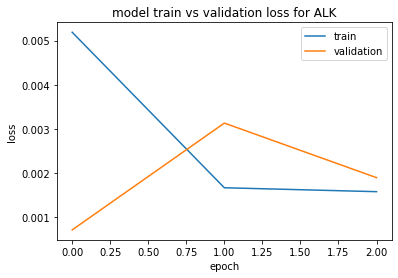

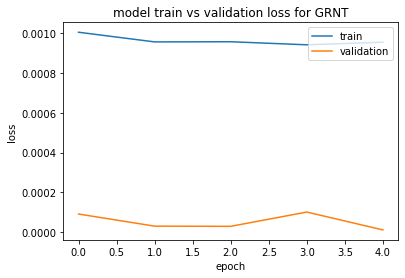

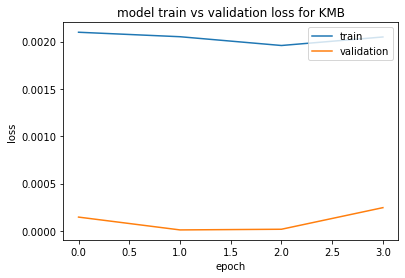

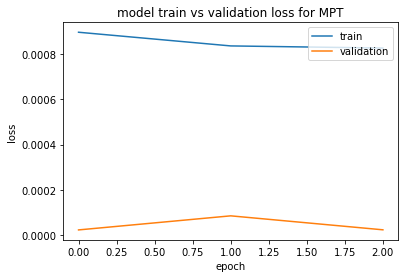

In [18]:
# plot train and validation loss
for i in range(4):
    plt.plot(history_list[i].history['loss'])
    plt.plot(history_list[i].history['val_loss'])
    plt.title('model train vs validation loss for {}'.format(stocks[i]))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [19]:
# make predictions
y_predictions = []
for i in range(4):
    yhat = model_many_to_many.predict(X_test_list[i], verbose=0)
    y_predictions.append(yhat)

In [20]:
y_predictions[0].shape

(7, 7, 1)

In [21]:
y_pred_reshape = []
y_actual_reshape = []
for i in range(4):
    yhat = y_predictions[i].reshape(y_predictions[i].shape[0]*y_predictions[i].shape[1],1)
    y_test = y_test_list[i].reshape(y_test_list[i].shape[0]*y_test_list[i].shape[1],1)
    y_pred_reshape.append(yhat)
    y_actual_reshape.append(y_test)
    

### inverse values from predicitons and actual labels

In [208]:
a = scaler.fit_transform(close_price[0].reshape(len(close_price[0]), 1))
alk_inverse_pred = scaler.inverse_transform(y_pred_reshape[0])
alk_inverse_actual = scaler.inverse_transform(y_actual_reshape[0])

In [209]:
g = scaler.fit_transform(close_price[1].reshape(len(close_price[1]), 1))
grnt_inverse_pred = scaler.inverse_transform(y_pred_reshape[1])
grnt_inverse_actual = scaler.inverse_transform(y_actual_reshape[1])

In [210]:
k = scaler.fit_transform(close_price[2].reshape(len(close_price[2]), 1))
kmb_inverse_pred = scaler.inverse_transform(y_pred_reshape[2])
kmb_inverse_actual = scaler.inverse_transform(y_actual_reshape[2])

In [211]:
m = scaler.fit_transform(close_price[3].reshape(len(close_price[3]), 1))
mpt_inverse_pred = scaler.inverse_transform(y_pred_reshape[3])
mpt_inverse_actual = scaler.inverse_transform(y_actual_reshape[3])

In [218]:
y_pred_list = []
y_actual_list = []
y_pred_list.extend((alk_inverse_pred, grnt_inverse_pred, kmb_inverse_pred, mpt_inverse_pred))
y_actual_list.extend((alk_inverse_actual, grnt_inverse_actual, kmb_inverse_actual, mpt_inverse_actual))

### score on test set

In [219]:
for i in range(4):
    print('RMSE for {}'.format(stocks[i]), np.sqrt(mean_squared_error(y_actual_list[i], y_pred_list[i])))

RMSE for ALK 231.35555498841563
RMSE for GRNT 8.719370640640028
RMSE for KMB 147.92728201463785
RMSE for MPT 1544.2897617738238


In [225]:
for i in range(4):
    print('RMSE on 7th day for {} is:'.format(stocks[i]), np.sqrt(mean_squared_error(y_actual_list[i][::7][-1], y_pred_list[i][::7][-1])))

RMSE on 7th day for ALK is: 233.6904296875
RMSE on 7th day for GRNT is: 4.8170166015625
RMSE on 7th day for KMB is: 110.08251953125
RMSE on 7th day for MPT is: 258.32421875


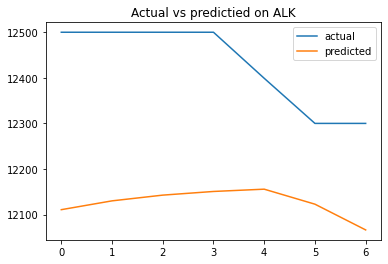

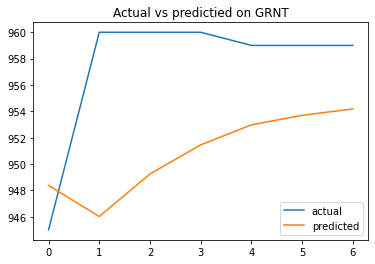

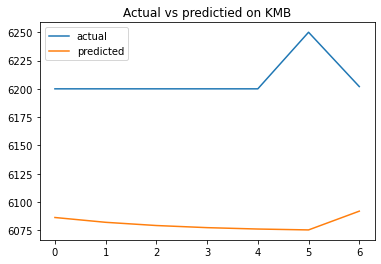

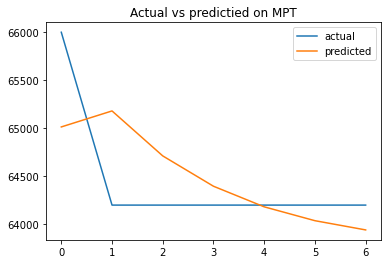

In [256]:
# plot the test data and predicitons
for i in range(4):
    plt.plot(y_actual_list[i][::7])
    plt.plot(y_pred_list[i][::7])
    plt.title('Actual vs predictied on {}'.format(stocks[i]))
    plt.legend(['actual', 'predicted'])
    plt.show()

### score on train and valdation dataset

In [233]:
y_train_pred_list = []
y_train_actual_list = []

for i in range(4):
    scale_by_stock = scaler.fit_transform(close_price[i].reshape(len(close_price[i]), 1))
    y_train_pred = model_many_to_many.predict(X_train_list[i])
    y_train_pred = scaler.inverse_transform(y_train_pred.reshape(y_train_pred.shape[0]*y_train_pred.shape[1],1))
    y_train_actual = scaler.inverse_transform(y_train_list[i].reshape(y_train_list[i].shape[0]*y_train_list[i].shape[1],1))
    y_train_pred_list.append(y_train_pred)
    y_train_actual_list.append(y_train_actual)

In [241]:
for i in range(4):
    train_score = np.sqrt(mean_squared_error(y_train_actual_list[i], y_train_pred_list[i]))
    print('Train RMSE for {} is: %.2f'.format(stocks[i]) % (train_score))

Train RMSE for ALK is: 226.83
Train RMSE for GRNT is: 40.44
Train RMSE for KMB is: 248.51
Train RMSE for MPT is: 2150.37


In [242]:
y_valid_pred_list = []
y_valid_actual_list = []

for i in range(4):
    scale_by_stock = scaler.fit_transform(close_price[i].reshape(len(close_price[i]), 1))
    y_valid_pred = model_many_to_many.predict(X_valid_list[i])
    y_valid_pred = scaler.inverse_transform(y_valid_pred.reshape(y_valid_pred.shape[0]*y_valid_pred.shape[1],1))
    y_valid_actual = scaler.inverse_transform(y_valid_list[i].reshape(y_valid_list[i].shape[0]*y_valid_list[i].shape[1],1))
    y_valid_pred_list.append(y_valid_pred)
    y_valid_actual_list.append(y_valid_actual)

In [258]:
for i in range(4):
    valid_score = np.sqrt(mean_squared_error(y_valid_actual_list[i], y_valid_pred_list[i]))
    print('Validation RMSE for {} is: %.2f'.format(stocks[i]) % (valid_score))

Validation RMSE for ALK is: 411.21
Validation RMSE for GRNT is: 8.26
Validation RMSE for KMB is: 117.63
Validation RMSE for MPT is: 832.82


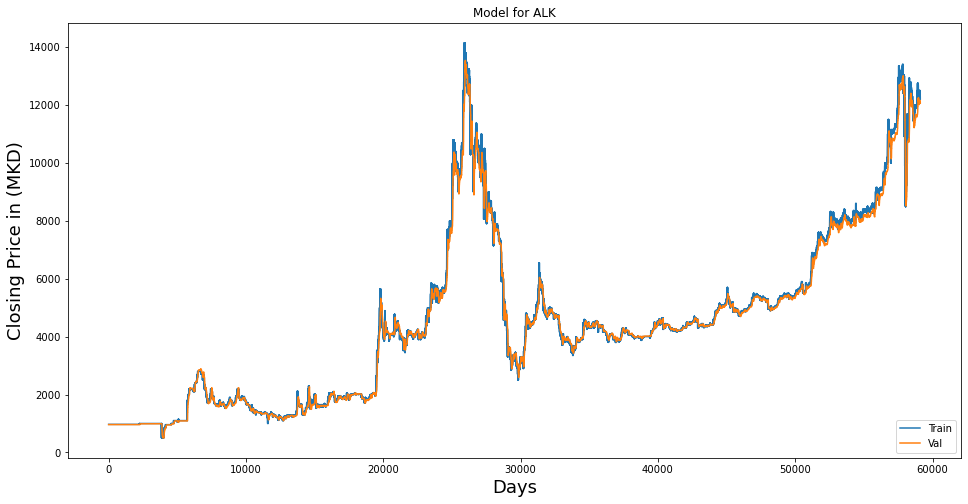

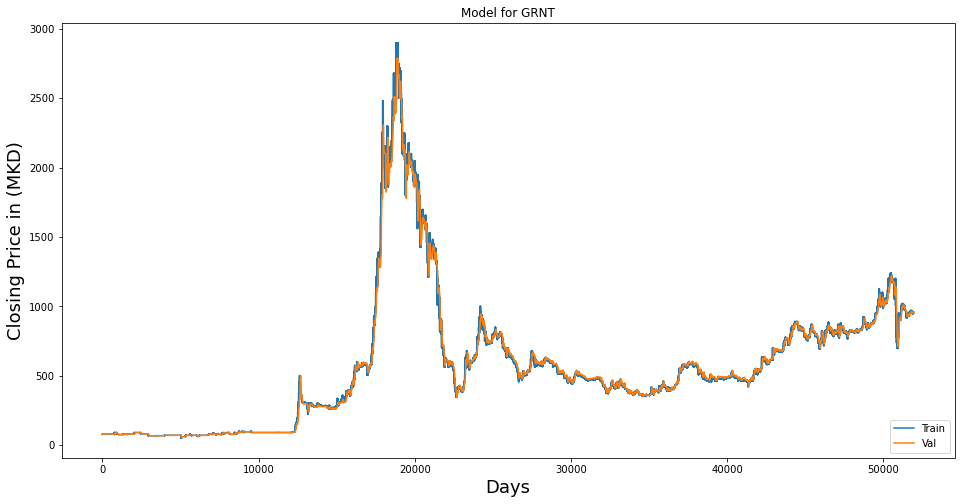

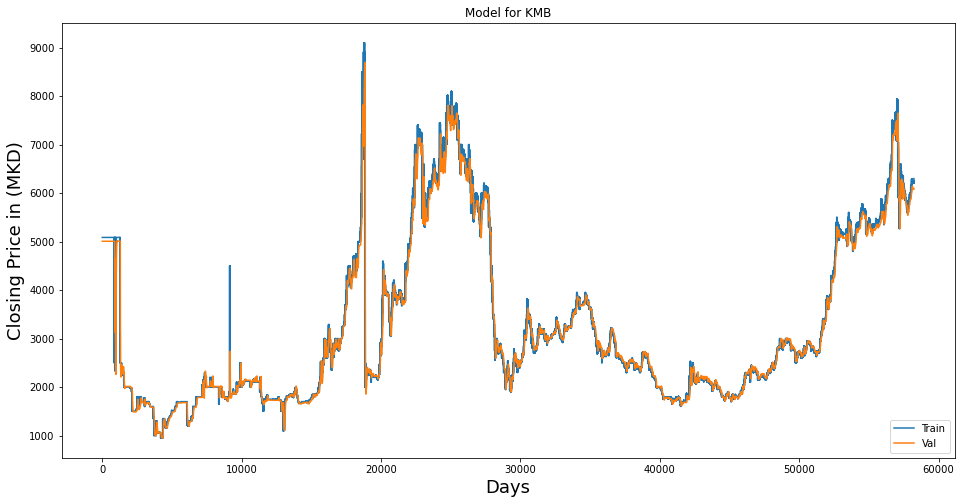

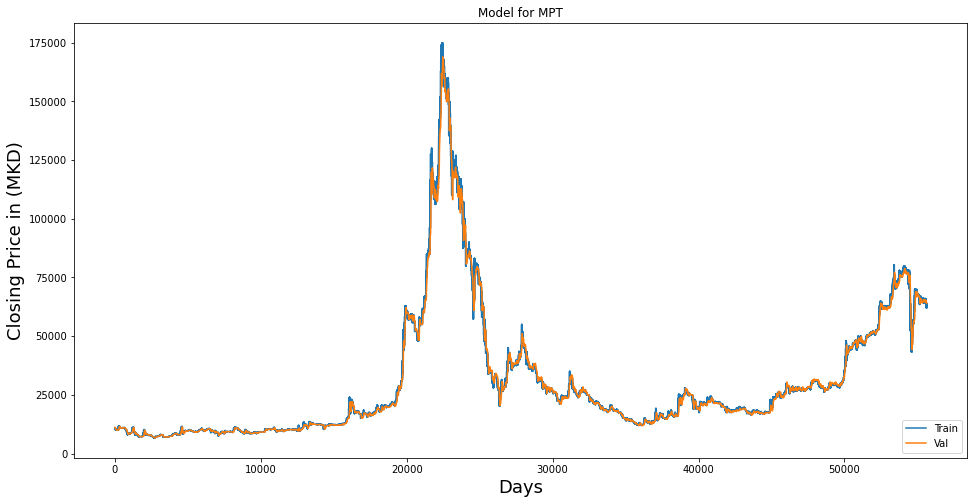

In [257]:
for i in range(4):
    #plot the data
    all_actual = np.concatenate([y_train_actual_list[i], y_valid_actual_list[i], y_actual_list[i]], axis=0)
    all_prediction = np.concatenate([y_train_pred_list[i], y_valid_pred_list[i], y_pred_list[i]], axis=0)
    #valid['Predictions'] = predictions
    #Visualize the Plot
    plt.figure(figsize=(16,8))
    plt.title('Model for {}'.format(stocks[i]))
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('Closing Price in (MKD)', fontsize=18)
    plt.plot(all_actual)
    plt.plot(all_prediction)
    plt.legend(['Train','Val'], loc= 'lower right')
    plt.show()

In [261]:
#create new data frame
new_df= close_price

In [267]:
#Get last 180 days closing price
last_180_days = []
for i in range(4):
    days_per_stock = new_df[i][-180:]
    last_180_days.append(days_per_stock)

In [286]:
#scale the data
last_180_days_scaled = []
for i in range(4):
    scaled = scaler.fit_transform(last_180_days[i].reshape(-1,1))
    last_180_days_scaled.append(scaled)

In [ ]:
#lets convert X_test to a Numpy array
X_test = np.array(X_test)

In [299]:
#Reshape the data to 3 dimentional
X_input = []
for i in range(4):
    reshaped_data = np.reshape(last_180_days_scaled[i],(last_180_days_scaled[i].shape[1],last_180_days_scaled[i].shape[0],1))
    X_input.append(reshaped_data)

In [300]:
#Get the predicted scaled price
X_output = []
for i in range(4):
    pred_price = model_many_to_many.predict(X_input[i])
    X_output.append(pred_price)

In [327]:
X_output[0].shape

(1, 7, 1)

In [336]:
a = scaler.fit_transform(last_180_days[0].reshape(-1, 1))
alk_inverse_pred = scaler.inverse_transform(X_output[0].reshape(X_output[0].shape[0]*X_output[0].shape[1],1))

In [337]:
print("The price for ALK on 7th day will be: ",np.round(alk_inverse_pred[-1].item(),0))

The price for ALK on 7th day will be:  12151.0


In [338]:
g = scaler.fit_transform(last_180_days[1].reshape(-1, 1))
grnt_inverse_pred = scaler.inverse_transform(X_output[1].reshape(X_output[1].shape[0]*X_output[1].shape[1],1))

In [339]:
print("The price for GRNT on 7th day will be: ",np.round(grnt_inverse_pred[-1].item(),0))

The price for GRNT on 7th day will be:  949.0


In [340]:
k = scaler.fit_transform(last_180_days[2].reshape(-1, 1))
kmb_inverse_pred = scaler.inverse_transform(X_output[2].reshape(X_output[2].shape[0]*X_output[2].shape[1],1))

In [342]:
print("The price for KMB on 7th day will be: ",np.round(kmb_inverse_pred[-1].item(),0))

The price for KMB on 7th day will be:  6252.0


In [343]:
m = scaler.fit_transform(last_180_days[3].reshape(-1, 1))
mpt_inverse_pred = scaler.inverse_transform(X_output[3].reshape(X_output[3].shape[0]*X_output[3].shape[1],1))

In [344]:
print("The price for MPT on 7th day will be: ",np.round(mpt_inverse_pred[-1].item(),0))

The price for MPT on 7th day will be:  61660.0
